# Transformer Apply for QQQ ETF

## 数据预处理：

In [1]:
import sys
sys.path.append('/workspaces/AI-Trader')
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler

# 读取数据
data = pd.read_csv('/workspaces/AI-Trader/data/raw/qqq_history.csv')

# 选择需要的列（如 'Close' 作为目标变量）
data = data[['Date', 'Close']]

# 转换日期格式并排序
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

# 归一化处理
scaler = MinMaxScaler(feature_range=(0, 1))
data['Close'] = scaler.fit_transform(data[['Close']])

# 创建时间序列数据
def create_sequences(data, seq_len):
    sequences = []
    targets = []
    for i in range(len(data) - seq_len):
        seq = data[i:i + seq_len]
        target = data[i + seq_len]
        sequences.append(seq)
        targets.append(target)
     # 添加特征维度
    sequences = torch.tensor(sequences, dtype=torch.float32).unsqueeze(-1)  # (batch_size, seq_len, 1)
    targets = torch.tensor(targets, dtype=torch.float32)
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

seq_len = 30  # 使用过去 30 天的数据预测未来
X, y = create_sequences(data['Close'].values, seq_len)

/tmp/ipykernel_113973/3362710582.py:14: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['Date'] = pd.to_datetime(data['Date'])
/tmp/ipykernel_113973/3362710582.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  sequences = torch.tensor(sequences, dtype=torch.float32).unsqueeze(-1)  # (batch_size, seq_len, 1)
/tmp/ipykernel_113973/3362710582.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(

## 模型训练

/tmp/ipykernel_113973/3021827333.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/tmp/ipykernel_113973/3021827333.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.float32)
/tmp/ipykernel_113973/3021827333.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)
/tmp/ipykernel_113973/3021827333.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().d

开始训练模型...
Epoch [1/50], Train Loss: 0.0923, Val Loss: 0.0891, Train Acc: 0.91, Val Acc: 1.00, LR: 0.001000
Model saved at epoch 1 with validation loss: 0.0891
Epoch [2/50], Train Loss: 0.0030, Val Loss: 0.0780, Train Acc: 1.00, Val Acc: 1.00, LR: 0.001000
Model saved at epoch 2 with validation loss: 0.0780
Epoch [3/50], Train Loss: 0.0030, Val Loss: 0.0778, Train Acc: 1.00, Val Acc: 1.00, LR: 0.001000
Model saved at epoch 3 with validation loss: 0.0778
Epoch [4/50], Train Loss: 0.0030, Val Loss: 0.0875, Train Acc: 1.00, Val Acc: 1.00, LR: 0.001000
Epoch [5/50], Train Loss: 0.0029, Val Loss: 0.0835, Train Acc: 1.00, Val Acc: 1.00, LR: 0.001000
Epoch [6/50], Train Loss: 0.0026, Val Loss: 0.0318, Train Acc: 1.00, Val Acc: 1.00, LR: 0.001000
Model saved at epoch 6 with validation loss: 0.0318
Epoch [7/50], Train Loss: 0.0005, Val Loss: 0.0155, Train Acc: 1.00, Val Acc: 1.00, LR: 0.001000
Model saved at epoch 7 with validation loss: 0.0155
Epoch [8/50], Train Loss: 0.0002, Val Loss: 0.0153,

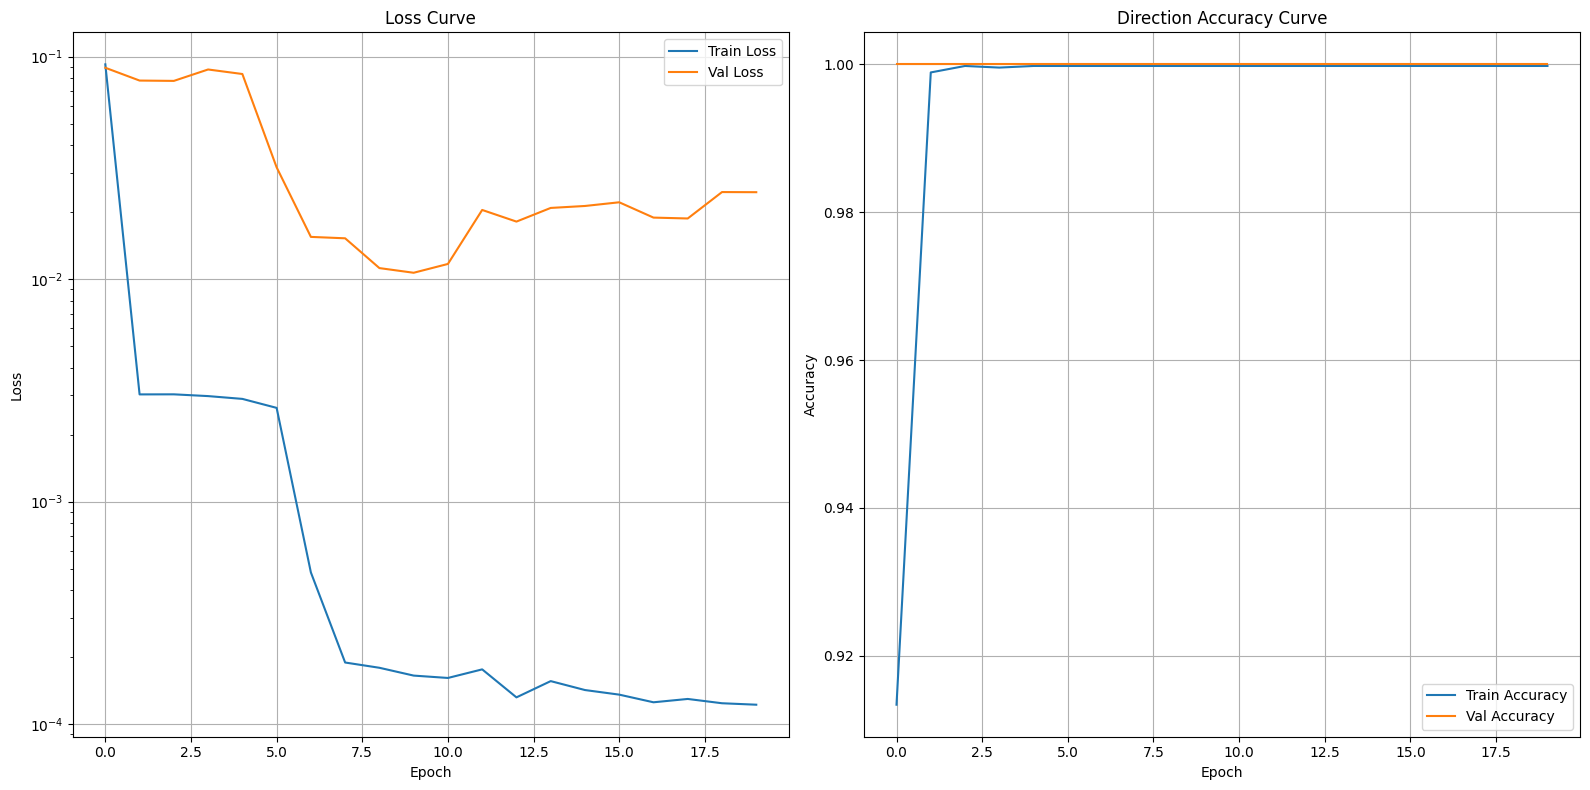

在测试集上评估模型...
Test Loss: 0.1644, Direction Accuracy: 1.00
详细评估指标:
MSE: 0.1644
MAE: 0.3748
方向准确率: 1.00


/tmp/ipykernel_113973/3021827333.py:165: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.savefig('prediction_results.png')
/tmp/ipykernel_113973/3021827333.py:165: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  plt.savefig('prediction_results.png')
/tmp/ipykernel_113973/3021827333.py:165: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.savefig('prediction_results.png')
/tmp/ipykernel_113973/3021827333.py:165: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from font(s) DejaVu Sans.
  plt.savefig('prediction_results.png')
/tmp/ipykernel_113973/3021827333.py:165: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from font(s) DejaVu Sans.
  plt.savefig('prediction_results.png')
/tmp/ipykernel_113973/3021827333.py:165: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) DejaVu Sans.
  

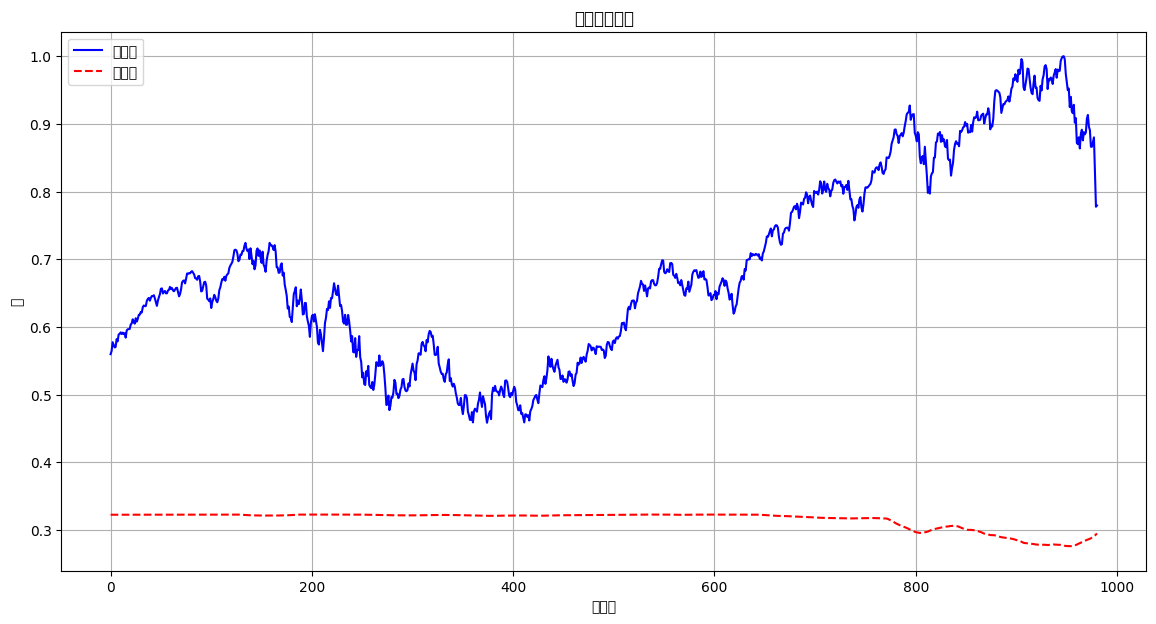

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from models.ml.transformer import TimeSeriesTransformer  # 导入优化后的模型

# 数据划分
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
test_size = len(X) - train_size - val_size
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

# 数据预处理
# 转换为PyTorch张量
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# 初始化模型
feature_dim = 1  # 每天只有一个特征（收盘价）
seq_len = X_train.shape[1]  # 序列长度
batch_size = 32  # 批处理大小

# 模型超参数
num_heads = 4  # 注意力头数
hidden_dim = 128  # 隐藏层维度
num_layers = 2  # Transformer层数
dropout = 0.1  # Dropout率

# 初始化模型
model = TimeSeriesTransformer(
    feature_dim=feature_dim,
    seq_len=seq_len,
    num_heads=num_heads,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout=dropout
)

# 使用GPU加速（如果可用）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
X_train = X_train.to(device)
X_val = X_val.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_val = y_val.to(device)
y_test = y_test.to(device)

# 初始化优化器和学习率调度器
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # 添加L2正则化
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# 训练模型并记录损失和方向准确率
num_epochs = 50
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')
patience = 10  # 早停耐心值
patience_counter = 0

print("开始训练模型...")
for epoch in range(num_epochs):
    # 训练阶段
    train_loss, train_acc = model.train_epoch(X_train, y_train, optimizer, batch_size=batch_size)
    
    # 验证阶段
    val_loss, val_acc = model.validate(X_val, y_val, batch_size=batch_size)
    
    # 学习率调度
    scheduler.step(val_loss)
    
    # 记录损失和准确率
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    # 打印进度
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train Acc: {train_acc:.2f}, Val Acc: {val_acc:.2f}, "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # 早停检查
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # 保存最佳模型
        torch.save(model.state_dict(), 'best_transformer_model.pth')
        print(f"Model saved at epoch {epoch + 1} with validation loss: {val_loss:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

# 加载最佳模型
model.load_state_dict(torch.load('best_transformer_model.pth'))
model.eval()  # 设置为评估模式

# 绘制损失曲线
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')  # 使用对数尺度更好观察损失变化
plt.grid(True)
plt.legend()
plt.title('Loss Curve')

# 绘制方向准确率曲线
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.title('Direction Accuracy Curve')
plt.tight_layout()
plt.savefig('transformer_training_curves.png')
plt.show()

# 测试集评估
print("在测试集上评估模型...")
test_loss, test_acc = model.validate(X_test, y_test, batch_size=batch_size)
print(f"Test Loss: {test_loss:.4f}, Direction Accuracy: {test_acc:.2f}")

# 预测并进一步评估
predictions = model.predict(X_test)
if torch.is_tensor(y_test):
    y_test_np = y_test.cpu().numpy()
else:
    y_test_np = y_test

mse = mean_squared_error(y_test_np, predictions)
mae = mean_absolute_error(y_test_np, predictions)
direction_accuracy = np.mean(np.sign(predictions) == np.sign(y_test_np))

print(f"详细评估指标:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"方向准确率: {direction_accuracy:.2f}")

# 可视化预测结果
plt.figure(figsize=(14, 7))
plt.plot(y_test_np, label='实际值', color='blue')
plt.plot(predictions, label='预测值', color='red', linestyle='--')
plt.title('预测结果对比')
plt.xlabel('时间步')
plt.ylabel('值')
plt.legend()
plt.grid(True)
plt.savefig('prediction_results.png')
plt.show()

## 预测与策略生成

In [3]:

# 预测
predictions = model.predict(X_test)

# 反归一化
predictions = scaler.inverse_transform(predictions.detach().numpy())
y_test = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [4]:
# 生成交易信号：根据预测值生成买入、卖出或持有信号：
import numpy as np

# 简单策略：如果预测价格高于当前价格，则买入；否则卖出
signals = []
for i in range(len(predictions)):
    if predictions[i] > y_test[i]:
        signals.append('Buy')
    else:
        signals.append('Sell')

# 将信号与日期对应
results = pd.DataFrame({
    'Date': data['Date'].iloc[train_size + seq_len:].values,
    'Actual': y_test.flatten(),
    'Predicted': predictions.flatten(),
    'Signal': signals
})
print(results.head())

                        Date      Actual   Predicted Signal
0  2020-01-27 00:00:00-05:00  211.204575 -288.426941   Sell
1  2020-01-28 00:00:00-05:00  214.448685 -288.426941   Sell
2  2020-01-29 00:00:00-05:00  214.797256 -288.426941   Sell
3  2020-01-30 00:00:00-05:00  215.562286 -288.426941   Sell
4  2020-01-31 00:00:00-05:00  212.143906 -288.426941   Sell


## 评估策略

In [5]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f'MSE: {mse:.4f}, RMSE: {rmse:.4f}')

MSE: 413447.2500, RMSE: 642.9986
